In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import uniform
from scipy.linalg import svd

import random

In [3]:
#Código do Zscore que fiz na lista 02, vou utilizar ele para normalizar os dados
class Zscore():
    def __init__(self, columnNumber = 2):
        self.__means = np.empty(columnNumber)
        self.__stds = np.empty(columnNumber)
        self.__quantity = 0
        
    def __setMeans(self, newMeans):
        self.__means = newMeans
    
    def getMeans(self):
        return self.__means
    
    def __setStds(self, newStds):
        self.__stds = newStds
    
    def getStds(self):
        return self.__stds
    
    def __setQuantity(self, newQ):
        self.__quantity = newQ
    
    def getQuantity(self):
        return self.__quantity
    
    def __addValues(self, mu, sigma):
        means = self.getMeans()
        stds = self.getStds()
        quantity = self.getQuantity()
        
        means[quantity] = mu
        stds[quantity] = sigma
        
        self.__setMeans(means)
        self.__setStds(stds)
        
        self.__setQuantity(quantity + 1)
    
    def scale(self, data):
        rows = data.shape[0]
        columns = data.shape[1]
        #Utiliza a Normalização Z-score, seria o equivalente ao Standard Scaler
        #Recebe um conjunto de dados e Retorna o mesmo conjunto de dados normalizado com média 0 e dp 1
        dataScaled = np.empty([rows, 0])
        for i in range(columns):
            #Esse método faz a normalização coluna por coluna, onde i é o número da coluna
            dataColumn = data[:, [i]]

            #Cálculo da média e desvio-padrão da coluna que vai ser normalizada
            mu = np.mean(dataColumn)
            sigma = np.std(dataColumn)

            columnScaled = (dataColumn - mu)/sigma
            #columnScaled = (xi - mu)/sigma
            #operação broadcasting para toda a coluna
            dataScaled = np.c_[dataScaled, columnScaled]
            
            self.__addValues(mu, sigma)
            #adiciona a coluna no dataset normalizado
        #print(dataScaled)
        return dataScaled
    
    def unscale(self, data, column = -1):
        # pensando em implementar um atributo dataset original
        # mas esse método tem como função principal fazer o "unscale" de novos atributos de um dado escalado
        # anteriormente, como por exemplo ŷ que é escalado na normal com base nos dados de y
        if column == -1:
            mu = self.getMeans()
            sigma = self.getStds()
            
        elif column >= self.getQuantity():
            print("ERRO: Número de Coluna ", column ," Inválida.")
            return
            
        else:
            mu = self.getMeans()[column]
            sigma = self.getStds()[column]
            
        return sigma * data + mu

In [3]:
def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

def mahalanobis(point, data):
    data = np.array(data)
    diff = point - data
    covariance = np.cov(data.T)  # Calcula a covariância dos dados
    inv_covariance = np.linalg.inv(covariance)
    mahalanobis_dist = np.sqrt(np.einsum('ij,ij->i', np.dot(diff, inv_covariance), diff))
    return mahalanobis_dist

class KMeans:    
    def __init__(self, n_clusters=8, max_iter=150, dist_type = "euclidean"):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        if dist_type == "mahalanobis":
            #print("Distância escolhida: Mahalanobis")
            self.dist = mahalanobis
        else: 
            #print("Distância escolhida: Euclidiana")
            self.dist = euclidean
        
        
    def initialize_centroids(self, X_train):
        centroids = []
        
        # Seleção do primeiro centroide aleatoriamente
        first_centroid = random.choice(X_train)
        centroids.append(first_centroid)
        
        # Seleção dos demais centroides usando o método k-means++
        for _ in range(1, self.n_clusters):
            distances = []
            for x in X_train:
                min_dist = min([np.linalg.norm(x - c) ** 2 for c in centroids])
                distances.append(min_dist)
            sum_distances = sum(distances)
            probabilities = [d / sum_distances for d in distances]
            next_centroid = random.choices(X_train, probabilities)[0]
            centroids.append(next_centroid)
        
        return centroids

    def fit(self, X_train):
        min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        self.centroids = self.initialize_centroids(X_train)
        
        iteration = 0
        prev_centroids = None
        
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            sorted_points = [[] for _ in range(self.n_clusters)]
            
            for x in X_train:
                dists = self.dist(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            
            prev_centroids = self.centroids
            self.centroids = []
            
            for cluster in sorted_points:
                if len(cluster) > 0:
                    new_centroid = np.mean(cluster, axis=0)
                    if np.isnan(new_centroid).any():
                        farthest_point = max(cluster, key=lambda point: np.linalg.norm(point - new_centroid))
                        self.centroids.append(farthest_point)
                    else:
                        self.centroids.append(new_centroid)
                else:
                    self.centroids.append(random.choice(X_train))
            
            iteration += 1
            
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = self.dist(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs


In [4]:
class PCA():
    def __init__(self, n_components=2):
        self.n_components = n_components
    
    def fit(self, X):
        n_samples = X.shape[0]
        X = X.copy()
        
        #Calcula a média e retira ela de cada X
        self.mean = np.mean(X, axis=0)
        X_meaned = (X - self.mean)
    
        # Calcula a matriz de covariância do X - Media
        # covariance_matrix = np.cov(X_meaned.T)
        # O método do PCA que implementei não utiliza a covariance_matrix
        
        #Encontra os autovetores e autovalores através do SVD(Singular Value Decomposition)
        U, singular_values, V = svd(X_meaned, full_matrices=False)
        eigen_values = singular_values ** 2
        eigen_vectors = V.T
        
        #Aqui ele "padroniza" os sinais, como os autovetores podem ser multiplicados por qualquer numero diferente
        #de 0, para "padronizar" as diferentes implementações de PCA eu vi que fazem isso para deixar
        #os componentes iguais, em questão de sinal
        #Fiz meu código comparando com as saídas do PCA do Sklearn, só resultou os componentes iguais quando apliquei
        #essa correção dos sinais
        max_abs_idx = np.argmax(np.abs(eigen_values), axis=0)
        signs = np.sign(eigen_vectors[max_abs_idx, range(eigen_vectors.shape[0])])
        eigen_vectors = eigen_vectors * signs[np.newaxis, :]
        eigen_vectors = eigen_vectors.T
       
        #Ordena pelo maior até o menor autovalor
        eig_pairs = [(np.abs(eigen_values[i]), eigen_vectors[i, :]) for i in range(len(eigen_values))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        eig_vals_sorted = np.array([x[0] for x in eig_pairs])
        eig_vecs_sorted = np.array([x[1] for x in eig_pairs])
        
        explained_variance = eig_vals_sorted / (n_samples - 1)
        total_variance = explained_variance.sum()
        explained_variance_ratio = explained_variance / total_variance
        
        self.components = eig_vecs_sorted[:self.n_components, :]
        self.singular_values = singular_values[:self.n_components]
        self.explained_variance = explained_variance[:self.n_components]
        self.explained_variance_ratio = explained_variance_ratio[:self.n_components]
    
    def transform(self, X):
        X = X.copy()
        X_meaned = (X - self.mean)
        X_reduced = X_meaned.dot(self.components.T)
        return X_reduced


In [5]:
def davies_bouldin_index(X, labels, centroids):
    k = len(np.unique(labels))
    centroids = np.array(centroids)
    labels = np.array(labels)
    cluster_distances = np.sqrt(np.sum((centroids[:, np.newaxis] - centroids) ** 2, axis=2))
    sigma_R = np.zeros(k)
    for i in range(k):
        cluster_i_indices = np.where(labels == i)[0]
        centroid_i = centroids[i]
        s_i = np.mean(np.sqrt(np.sum((X[cluster_i_indices] - centroid_i) ** 2, axis=1)))

        R_values = np.zeros(k)
        for j in range(k):
            if j != i:
                cluster_j_indices = np.where(labels == j)[0]
                centroid_j = centroids[j]
                s_j = np.mean(np.sqrt(np.sum((X[cluster_j_indices] - centroid_j) ** 2, axis=1)))
                R_values[j] = (s_i + s_j) / cluster_distances[i, j]
                
        sigma_R[i] = np.max(R_values)
    DB_index = np.mean(sigma_R)
    return DB_index

In [6]:
quake = np.loadtxt(".//ama_lista_06//quake.csv", delimiter = ",")
quake

array([[-52.26,  28.3 ],
       [ 45.53, 150.93],
       [ 41.85, 142.78],
       ...,
       [ 27.87, 139.51],
       [ 36.43, 140.98],
       [ 24.02, 122.23]])

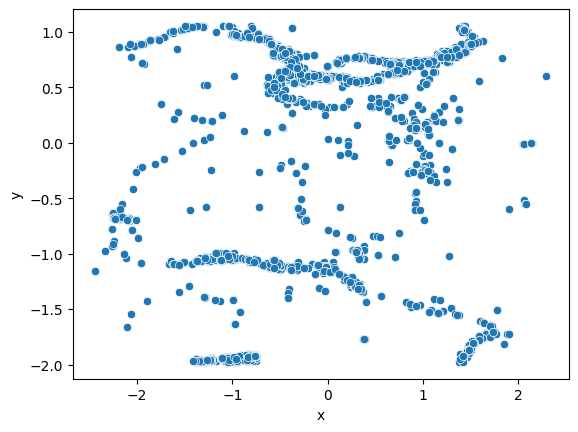

In [7]:
normalizer =  Zscore(quake.shape[1])
X_train = normalizer.scale(quake)
#X_train = quake
sns.scatterplot(x=[X[0] for X in X_train],
                y=[X[1] for X in X_train],
                legend=None
                )
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [8]:
errors_ = []
centroids_ = []
labels_ = []

for i in range(4, 21):
    errors_values = []
    DB_index_values = []
    models = []
    class_centers_ = [] 
    classification_ = [] 
    
    for j in range(10):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X_train)
        class_centers, classification = kmeans.evaluate(X_train)
        # class_centers é o centroide que aquela posição pertence
        
        class_centers_.append(kmeans.centroids)
        classification_.append(classification)
        value = davies_bouldin_index(X_train, classification, kmeans.centroids)
        DB_index_values.append(value)
    
    centroids_.append(class_centers_[DB_index_values.index(min(DB_index_values))])
    labels_.append(classification_[DB_index_values.index(min(DB_index_values))])
    
    errors_.append(min(DB_index_values))
    print(i, "--- OK = ", min(DB_index_values))
    

4 --- OK =  0.5967974949830196
5 --- OK =  0.6187960476471008
6 --- OK =  0.6175404812991155
7 --- OK =  0.6033876837939793
8 --- OK =  0.5718453189467869
9 --- OK =  0.6517241115600709
10 --- OK =  0.6117848765143943
11 --- OK =  0.5779215230665153
12 --- OK =  0.5513939704100227
13 --- OK =  0.5627263685149825
14 --- OK =  0.5866548567523225
15 --- OK =  0.5720659530649851
16 --- OK =  0.5941192392128741
17 --- OK =  0.5946072688922266
18 --- OK =  0.5911873645378167
19 --- OK =  0.5702269633777796
20 --- OK =  0.6174319788846746


In [9]:
num_clusters = errors_.index(min(errors_)) + 4

print(num_clusters)
print(min(errors_))

best_labels = labels_[errors_.index(min(errors_))]
best_centroids = centroids_[errors_.index(min(errors_))]

12
0.5513939704100227


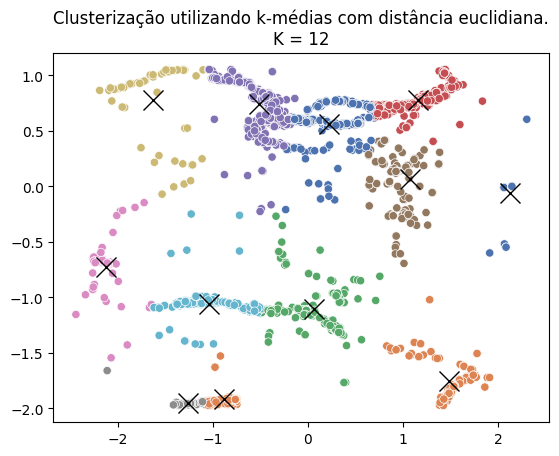

0.5513939704100227


In [10]:
sns.scatterplot(x=[X[0] for X in X_train],
                y=[X[1] for X in X_train],
                hue = best_labels,
                palette="deep",
                legend=None
                )
plt.plot([x for x, _ in best_centroids],
         [y for _, y in best_centroids],
         'x',
         markersize=15, color = "black"
         )
plt.title(f"Clusterização utilizando k-médias com distância euclidiana.\nK = {num_clusters}")

plt.show()

value = davies_bouldin_index(X_train, best_labels, best_centroids)
print(value)

In [11]:
errors_ = []
centroids_ = []
labels_ = []

for i in range(4, 21):
    errors_values = []
    DB_index_values = []
    models = []
    class_centers_ = [] 
    classification_ = [] 
    
    # Coloquei apenas 5 clusters pois com 10 ou 20 tava demorando MUITO
    for j in range(5):
        kmeans = KMeans(n_clusters=i,dist_type = "mahalanobis")
        kmeans.fit(X_train)
        class_centers, classification = kmeans.evaluate(X_train)
        # class_centers é o centroide que aquela posição pertence
        
        class_centers_.append(kmeans.centroids)
        classification_.append(classification)
        value = davies_bouldin_index(X_train, classification, kmeans.centroids)
        DB_index_values.append(value)
    
    centroids_.append(class_centers_[DB_index_values.index(min(DB_index_values))])
    labels_.append(classification_[DB_index_values.index(min(DB_index_values))])
    
    errors_.append(min(DB_index_values))
    print(i, "--- OK = ", min(DB_index_values))

4 --- OK =  0.5967974949830196
5 --- OK =  0.6173521901633571
6 --- OK =  0.7049729784195753
7 --- OK =  0.6115105398446807
8 --- OK =  0.6385891569028864
9 --- OK =  0.6396183716864081
10 --- OK =  0.6156220550863084
11 --- OK =  0.5914668976863405
12 --- OK =  0.5985497634976168
13 --- OK =  0.6379238034313313
14 --- OK =  0.6388268982882133
15 --- OK =  0.6015846587743054
16 --- OK =  0.5901839430365561
17 --- OK =  0.6409271373305165
18 --- OK =  0.583128086239176
19 --- OK =  0.568676210701067
20 --- OK =  0.6083245071243637


In [12]:
num_clusters = errors_.index(min(errors_)) + 4

print(num_clusters)
print(min(errors_))

best_labels = labels_[errors_.index(min(errors_))]
best_centroids = centroids_[errors_.index(min(errors_))]

19
0.568676210701067


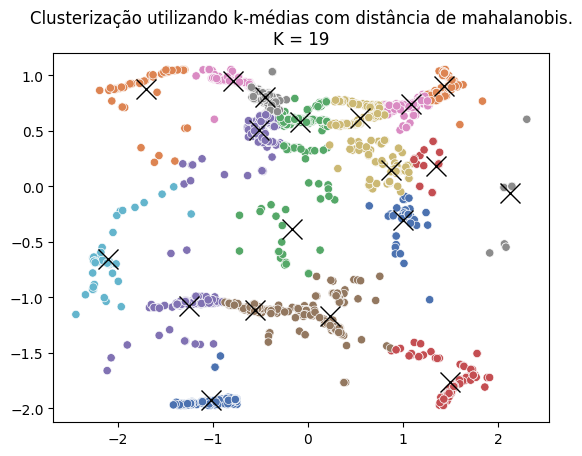

0.568676210701067


In [13]:
sns.scatterplot(x=[X[0] for X in X_train],
                y=[X[1] for X in X_train],
                hue = best_labels,
                palette="deep",
                legend=None
                )
plt.plot([x for x, _ in best_centroids],
         [y for _, y in best_centroids],
         'x',
         markersize=15, color = "black"
         )
plt.title(f"Clusterização utilizando k-médias com distância de mahalanobis.\nK = {num_clusters}")

plt.show()

value = davies_bouldin_index(X_train, best_labels, best_centroids)
print(value)

In [5]:
penguin = np.loadtxt(".//ama_lista_06//penguins.csv", delimiter = ",")
penguin

array([[3.910e+01, 1.870e+01, 1.810e+02, 3.750e+03, 0.000e+00],
       [3.950e+01, 1.740e+01, 1.860e+02, 3.800e+03, 0.000e+00],
       [4.030e+01, 1.800e+01, 1.950e+02, 3.250e+03, 0.000e+00],
       ...,
       [4.960e+01, 1.820e+01, 1.930e+02, 3.775e+03, 1.000e+00],
       [5.080e+01, 1.900e+01, 2.100e+02, 4.100e+03, 1.000e+00],
       [5.020e+01, 1.870e+01, 1.980e+02, 3.775e+03, 1.000e+00]])

In [6]:
normalizer =  Zscore(penguin.shape[1])
dataset_scaled = normalizer.scale(penguin)

dataset_scaled

array([[-0.89604189,  0.7807321 , -1.42675157, -0.56847478, -1.03437424],
       [-0.82278787,  0.11958397, -1.06947358, -0.50628618, -1.03437424],
       [-0.67627982,  0.42472926, -0.42637319, -1.1903608 , -1.03437424],
       ...,
       [ 1.02687621,  0.52644436, -0.56928439, -0.53738048,  0.09126832],
       [ 1.24663828,  0.93330475,  0.64546078, -0.13315457,  0.09126832],
       [ 1.13675725,  0.7807321 , -0.2120064 , -0.53738048,  0.09126832]])

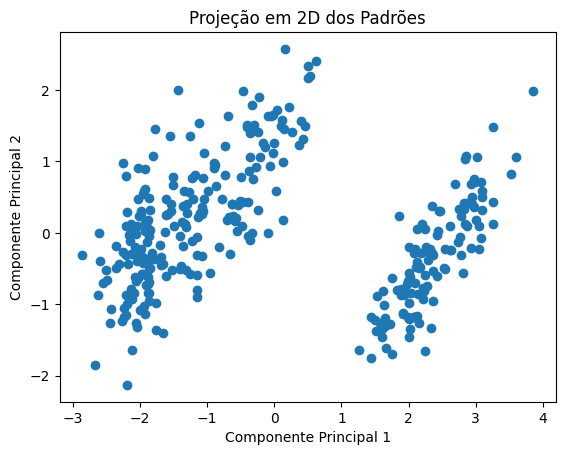

In [7]:
pca = PCA(n_components=2)
pca.fit(dataset_scaled)
dataset_pca = pca.transform(dataset_scaled)
# Plotando a projeção em 2D dos dados
plt.scatter(dataset_pca[:, 0], dataset_pca[:, 1])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção em 2D dos Padrões')
plt.show()

In [8]:
pca = PCA(4)
pca.fit(dataset_scaled)
var_explicada = pca.explained_variance
var_explicada_pr =  pca.explained_variance_ratio

# Mostrar a variância explicada para cada dimensão
for i in range(1, 5):
    print(f"Dimensão {i}: Variância explicada = {var_explicada[i - 1]:.4f}")
    print(f"Dimensão {i}: Razão da variância explicada = {var_explicada_pr[i-1]:.4f}\n")

Dimensão 1: Variância explicada = 3.6473
Dimensão 1: Razão da variância explicada = 0.7273

Dimensão 2: Variância explicada = 0.7889
Dimensão 2: Razão da variância explicada = 0.1573

Dimensão 3: Variância explicada = 0.4144
Dimensão 3: Razão da variância explicada = 0.0826

Dimensão 4: Variância explicada = 0.1083
Dimensão 4: Razão da variância explicada = 0.0216

